In [5]:
import jieba
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re
import math
import os

# ==================== 配置参数 ====================
CORPUS_PATH = r"C:\Users\30507\Desktop\DL-NLP-2025-LSX-main\hw2\data\三十三剑客图.txt"
VEC_DIM = 100
CTX_RANGE = 10
CLIP_VALUE = 100
WEIGHT_EXP = 0.75
TRAIN_EPOCHS = 50
SAMPLE_BATCH = 1024
MIN_COUNT = 5
LEARNING_RATE = 0.05

# ==================== 文本预处理 ====================
class TextCooccurrenceLoader(Dataset):  # 原GloVeDataset
    def __init__(self, cooccurrence_pairs):
        self.samples = [(idx_i, idx_j, cnt) for (idx_i, idx_j), cnt in cooccurrence_pairs.items()]
        self.weight_values = [self._compute_weight(cnt) for (idx_i, idx_j, cnt) in self.samples]
        
    def _compute_weight(self, value):
        return (value / CLIP_VALUE)**WEIGHT_EXP if value < CLIP_VALUE else 1.0
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        i, j, cooccur = self.samples[index]
        return (
            torch.LongTensor([i]),
            torch.LongTensor([j]),
            torch.FloatTensor([cooccur]),
            torch.FloatTensor([self.weight_values[index]])
        )

def construct_word_cooccurrence(input_file):
    with open(input_file, 'r', encoding='gb18030') as file:
        text = re.sub(r'\s+', '', file.read())
    
    tokenized_words = list(jieba.cut(text))
    
    frequency_dict = defaultdict(int)
    for word in tokenized_words:
        frequency_dict[word] += 1
    word_mapping = {'<PAD>':0, '<UNK>':1}
    current_idx = 2
    for term, freq in frequency_dict.items():
        if freq >= MIN_COUNT:
            word_mapping[term] = current_idx
            current_idx += 1
    idx_to_term = {v:k for k,v in word_mapping.items()}
    
    cooccur_dict = defaultdict(float)
    for pos in range(len(tokenized_words)):
        center_term = tokenized_words[pos]
        if center_term not in word_mapping:
            continue
        center_id = word_mapping[center_term]
        
        window_start = max(0, pos - CTX_RANGE)
        window_end = min(len(tokenized_words), pos + CTX_RANGE + 1)
        
        for ctx_pos in range(window_start, window_end):
            if ctx_pos == pos:
                continue
            ctx_term = tokenized_words[ctx_pos]
            if ctx_term not in word_mapping:
                continue
            ctx_id = word_mapping[ctx_term]
            
            position_diff = abs(ctx_pos - pos)
            cooccur_dict[(center_id, ctx_id)] += 1.0 / position_diff
    
    return word_mapping, idx_to_term, cooccur_dict

# ==================== 嵌入模型 ====================
class WordEmbeddingModel(nn.Module):  # 原GloVe
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding_i = nn.Embedding(vocab_size, VEC_DIM)
        self.embedding_j = nn.Embedding(vocab_size, VEC_DIM)
        self.bias_i = nn.Embedding(vocab_size, 1)
        self.bias_j = nn.Embedding(vocab_size, 1)
        
        nn.init.uniform_(self.embedding_i.weight, -0.5/VEC_DIM, 0.5/VEC_DIM)
        nn.init.uniform_(self.embedding_j.weight, -0.5/VEC_DIM, 0.5/VEC_DIM)
        nn.init.constant_(self.bias_i.weight, 0.0)
        nn.init.constant_(self.bias_j.weight, 0.0)
    
    def forward(self, center_indices, ctx_indices, cooccur_values, weight_factors):
        w_center = self.embedding_i(center_indices)
        w_context = self.embedding_j(ctx_indices)
        b_center = self.bias_i(center_indices).squeeze()
        b_ctx = self.bias_j(ctx_indices).squeeze()
        
        dot_product = torch.sum(w_center * w_context, dim=1) + b_center + b_ctx
        loss = weight_factors * torch.pow(dot_product - torch.log(cooccur_values), 2)
        return torch.mean(loss)

# ==================== 模型训练 ====================
def train_embedding_model(vocabulary, cooccurrence_dict):
    training_data = TextCooccurrenceLoader(cooccurrence_dict)
    data_loader = DataLoader(training_data, batch_size=SAMPLE_BATCH, shuffle=True)
    
    model = WordEmbeddingModel(len(vocabulary))
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    for epoch in range(TRAIN_EPOCHS):
        epoch_loss = 0.0
        for center_ids, ctx_ids, cooccur_vals, weights in data_loader:
            optimizer.zero_grad()
            loss = model(center_ids.squeeze(), ctx_ids.squeeze(), 
                        cooccur_vals.squeeze(), weights.squeeze())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{TRAIN_EPOCHS}, Loss: {epoch_loss/len(data_loader):.4f}")
    
    final_embeddings = model.embedding_i.weight.data + model.embedding_j.weight.data
    return final_embeddings.numpy()

# ==================== 分析工具 ====================
class EmbeddingAnalyzer:
    def __init__(self, embedding_vectors, word_mapping, idx_to_term):
        self.embedding_vectors = embedding_vectors
        self.word_mapping = word_mapping
        self.idx_to_term = idx_to_term
        
    def retrieve_vector(self, term):
        if term not in self.word_mapping:
            return None
        return self.embedding_vectors[self.word_mapping[term]]
    
    def find_similar_words(self, query_word, top_k=5):
        query_vec = self.retrieve_vector(query_word)
        if query_vec is None:
            return []
        
        similarity_scores = []
        for vec_idx in range(len(self.embedding_vectors)):
            if vec_idx == self.word_mapping[query_word]:
                continue
            score = cosine_similarity([query_vec], [self.embedding_vectors[vec_idx]])[0][0]
            similarity_scores.append((self.idx_to_term[vec_idx], score))
        return sorted(similarity_scores, key=lambda x: -x[1])[:top_k]
    
    def display_cluster_visualization(self, terms):
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        
        vectors_to_plot = []
        term_labels = []
        for term in terms:
            if term in self.word_mapping:
                vectors_to_plot.append(self.embedding_vectors[self.word_mapping[term]])
                term_labels.append(term)
        
        pca_reducer = PCA(n_components=2)
        reduced_points = pca_reducer.fit_transform(vectors_to_plot)
        
        plt.figure(figsize=(12,8))
        plt.scatter(reduced_points[:,0], reduced_points[:,1], c='green')
        for idx, label in enumerate(term_labels):
            plt.annotate(label, (reduced_points[idx,0], reduced_points[idx,1]))
        plt.title("词语嵌入可视化")
        plt.show()
    
    def compare_text_similarity(self, text_a, text_b):
        def text_to_vector(text):
            terms = jieba.cut(text)
            vectors = [self.retrieve_vector(w) for w in terms if w in self.word_mapping]
            return np.mean(vectors, axis=0) if vectors else None
        
        vec_a = text_to_vector(text_a)
        vec_b = text_to_vector(text_b)
        if vec_a is None or vec_b is None:
            return 0.0
        return cosine_similarity([vec_a], [vec_b])[0][0]

In [19]:
vocab, id2word, cooccurrence = construct_word_cooccurrence(CORPUS_PATH)
print(f"词汇表大小: {len(vocab)}")

# 训练模型
embeddings = train_embedding_model(vocab, cooccurrence)

# 初始化验证器
validator = EmbeddingAnalyzer(embeddings, vocab, id2word)

词汇表大小: 1002
Epoch 1/50, Loss: 0.0570
Epoch 2/50, Loss: 0.0497
Epoch 3/50, Loss: 0.0543
Epoch 4/50, Loss: 0.0583
Epoch 5/50, Loss: 0.0759
Epoch 6/50, Loss: 0.1160
Epoch 7/50, Loss: 0.1279
Epoch 8/50, Loss: 0.1095
Epoch 9/50, Loss: 0.0877
Epoch 10/50, Loss: 0.0727
Epoch 11/50, Loss: 0.0661
Epoch 12/50, Loss: 0.0629
Epoch 13/50, Loss: 0.0589
Epoch 14/50, Loss: 0.0484
Epoch 15/50, Loss: 0.0440
Epoch 16/50, Loss: 0.0448
Epoch 17/50, Loss: 0.0597
Epoch 18/50, Loss: 0.1209
Epoch 19/50, Loss: 0.3021
Epoch 20/50, Loss: 0.3901
Epoch 21/50, Loss: 0.4384
Epoch 22/50, Loss: 0.4166
Epoch 23/50, Loss: 0.3830
Epoch 24/50, Loss: 0.3855
Epoch 25/50, Loss: 0.2270
Epoch 26/50, Loss: 0.1464
Epoch 27/50, Loss: 0.0927
Epoch 28/50, Loss: 0.0535
Epoch 29/50, Loss: 0.0536
Epoch 30/50, Loss: 0.0408
Epoch 31/50, Loss: 0.0367
Epoch 32/50, Loss: 0.0479
Epoch 33/50, Loss: 0.0571
Epoch 34/50, Loss: 0.0901
Epoch 35/50, Loss: 0.0428
Epoch 36/50, Loss: 0.0353
Epoch 37/50, Loss: 0.0180
Epoch 38/50, Loss: 0.0214
Epoch 39/


【剑客】相似词:
[('想象', np.float32(0.33584228)), ('道家', np.float32(0.31306478)), ('丰富', np.float32(0.3032158)), ('得到', np.float32(0.28553933)), ('所说', np.float32(0.27920234))]

聚类可视化:


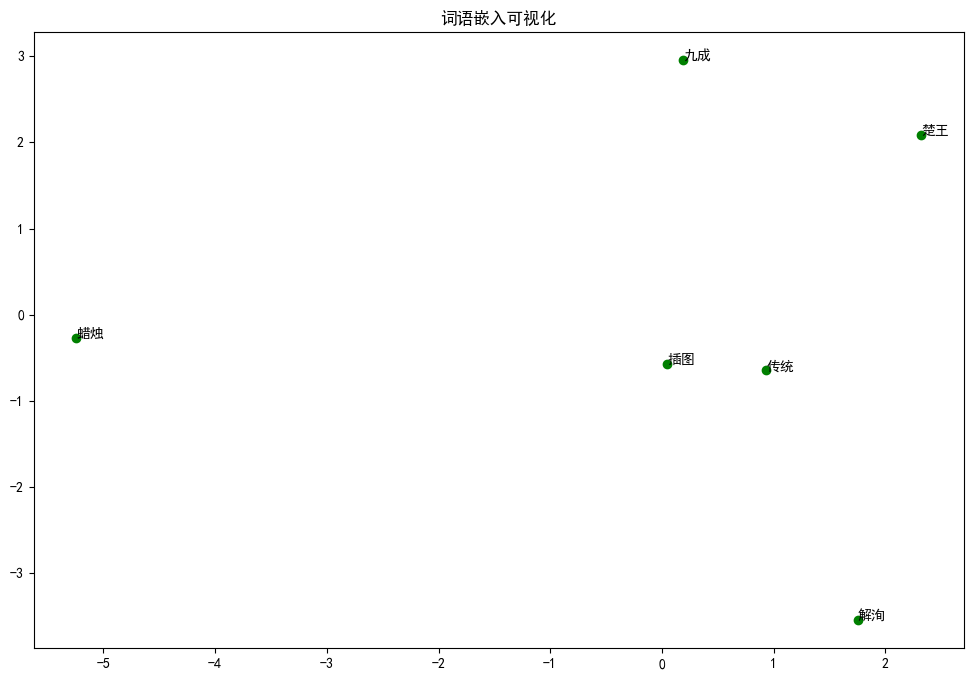


段落相似度: 0.4481


In [20]:
print("\n【剑客】相似词:")
print(validator.find_similar_words('剑客'))

print("\n聚类可视化:")
validator.display_cluster_visualization(['传统', '插图', '蜡烛', '楚王', '解洵', "九成"])

para1 = "旧小说有插图和绣像，是我国向来的传统。"
para2 = "江苏与浙江到宋朝时已渐渐成为中国的经济与文化中心，苏州、杭州成为出产文化和美女的地方。"
print(f"\n段落相似度: {validator.compare_text_similarity(para1, para2):.4f}")